In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
import pickle as p
import io 

In [4]:
limit_gpus()
set_gpu(2)

In [5]:
dataset = "mnist"
n_batch = 256

ds_train, ds_test, ds_info = load_dataset(dataset)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes


In [6]:
ds_test = ds_test.batch(n_batch)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
head = keras.models.load_model("ae_conv_head.h5")
head.compile()

inv_head = keras.models.load_model("ae_inv_head.h5")
inv_head.compile()

In [8]:
n_d = 1000
n_hidden = 100

image_input = keras.Input(shape=input_shape)
class_input = keras.Input(shape=(n_d,))

In [9]:
dat_x, dat_y = get_raw_dat(ds_train.batch(128))

In [10]:
cdp = class_data_pairs(dat_x,dat_y)

12665
12089
11263
12183
11800


In [11]:
def conf_acc(model):
    conf = model.accuracy(ds_test, True)[0]
    acc = confusion_to_acc(conf)
    print(acc)
    plt.pcolor(conf)

In [12]:
plotconf = lambda: conf_acc(incm)

In [13]:
def match_normalize(source, dest):
    norm = source.img_encoder.norm_symbols
    mm = norm.moving_mean
    ms = norm.moving_std
    
    norm2 = dest.img_encoder.norm_symbols
    norm2.moving_mean = mm
    norm2.moving_std = ms

In [14]:
incm = IrisModel(head, inv_head, ds_info, n_d=n_d, n_hidden=n_hidden, sigma=3.0, overscan=100)
incm.compile(optimizer="rmsprop")

In [15]:
incm.save_weights("si_step0")

In [16]:
incm.img_encoder.norm_symbols.fixed = True
incm.img_encoder.norm_symbols.moving_mean = 0.00576
incm.img_encoder.norm_symbols.moving_std = 5.0737

# train on first dataset

In [17]:
ext1 = incm.generate_external(cdp[0].batch(128), True)

In [18]:
incm.optimizer.learning_rate = 0.0005

In [19]:
loss = incm.train(ext1,1)

Training loss [0.98868394 0.99867505 1.0017077  0.98268783]


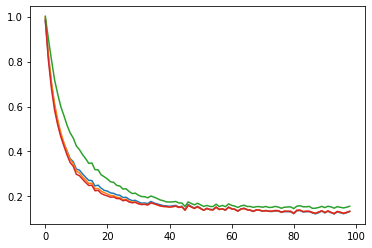

In [20]:
plt.plot(loss)

0.2113


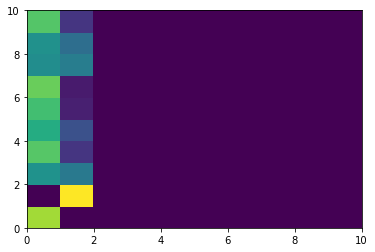

In [21]:
plotconf()

In [22]:
modelname = "si_step1"

In [23]:
incm.save_weights(modelname)

# Train on second set

In [25]:
h1, lh1 = incm.reconstruct_info(5000, 400, optimizer=keras.optimizers.RMSprop(lr=0.01))

[1.0008972 1.0007066]
[0.38044482 0.45707616]
[0.1708063  0.21041778]
[0.0940368  0.10689081]


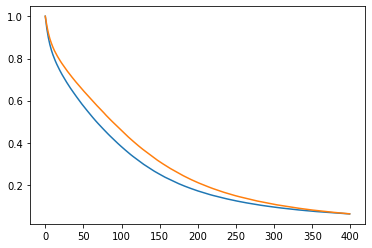

In [26]:
plt.plot(lh1)

In [27]:
old1 = incm.generate_internal(h1, truefwd=False)

In [44]:
incm.load_weights("si_step1")

In [45]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[1], old1, 200, split=[128, 8])

Training loss [0.02719559 0.03044832 0.05719987 0.02972024]
Training loss [0.02236805 0.01829631 0.01701955 0.01774669]


0.3733


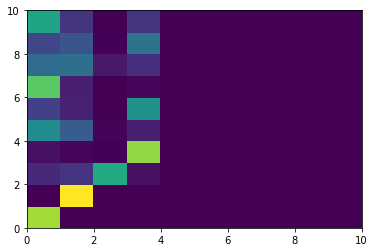

In [46]:
plotconf()

In [47]:
incm.save_weights("si_step2")

# Train on third set

In [48]:
h2, lh2 = incm.reconstruct_info(5000, 400, optimizer=keras.optimizers.RMSprop(lr=0.01))

[1.0004396 1.0003903]
[0.29889584 0.34377614]
[0.12183065 0.12897012]
[0.06827678 0.06234346]


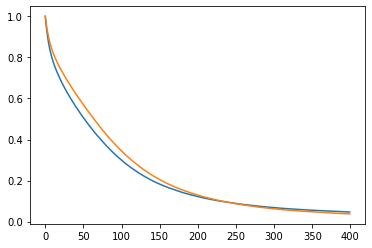

In [49]:
plt.plot(lh2)

In [50]:
old2 = incm.generate_internal(h2, truefwd=False)

In [51]:
incm.load_weights("si_step2")

In [52]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[2], old2, 200, split=[128, 8])

Training loss [0.02589233 0.027864   0.05547184 0.02736111]
Training loss [0.02271221 0.01807233 0.01581308 0.01674574]


0.4314


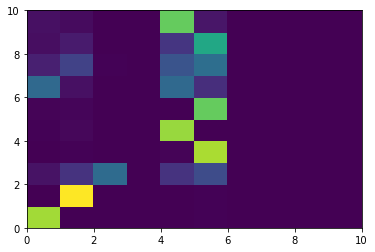

In [53]:
plotconf()

In [54]:
incm.train(old2, 1)

Training loss [0.00693441 0.00393111 0.00236688 0.00358463]


array([[0.00693441, 0.00393111, 0.00236688, 0.00358463],
       [0.0058293 , 0.00378868, 0.00259396, 0.00288814],
       [0.00504377, 0.00333421, 0.002088  , 0.00294043],
       [0.00396882, 0.00309645, 0.00179176, 0.00229264],
       [0.00423384, 0.00273307, 0.00217903, 0.00263757],
       [0.00406794, 0.00319928, 0.00201234, 0.00289813],
       [0.00417509, 0.00305382, 0.00200924, 0.00275725],
       [0.00392271, 0.0027548 , 0.00234226, 0.00271319],
       [0.00427541, 0.0028517 , 0.00215102, 0.00261257],
       [0.00304236, 0.00233448, 0.00176901, 0.00176028],
       [0.00371536, 0.00344386, 0.00301264, 0.00278858],
       [0.00475594, 0.00344664, 0.00328966, 0.00247985],
       [0.00374019, 0.00311479, 0.00383261, 0.00242085],
       [0.00381888, 0.00300472, 0.00400115, 0.00253075],
       [0.00397682, 0.00310954, 0.0032126 , 0.00244133],
       [0.00480158, 0.00342647, 0.00352269, 0.0031701 ],
       [0.0042875 , 0.00301367, 0.00325091, 0.00310613],
       [0.00378423, 0.00299877,

0.4641


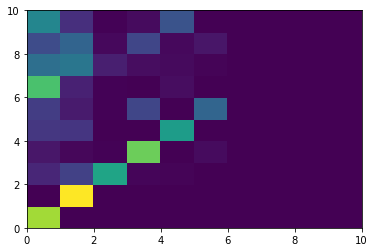

In [55]:
plotconf()

In [56]:
incm.save_weights("si_step3")

# Train on fourth set

In [57]:
incm.load_weights("si_step3")

In [58]:
h3, lh3 = incm.reconstruct_info(5000, 400, optimizer=keras.optimizers.RMSprop(lr=0.01))

[0.9988533 1.0003949]
[0.22873709 0.24809282]
[0.08751725 0.08139855]
[0.05092115 0.04035288]


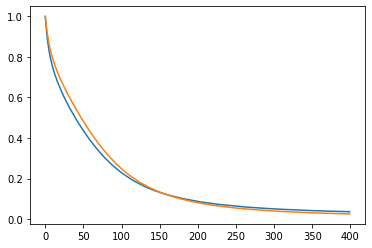

In [59]:
plt.plot(lh3)

In [60]:
old3 = incm.generate_internal(h3, truefwd=False)

In [61]:
incm.load_weights("si_step3")

In [62]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[3], old3, 200, split=[128, 8])

Training loss [0.02416128 0.02519109 0.06121648 0.02455562]
Training loss [0.01936282 0.01481262 0.0139647  0.0139531 ]


0.4135


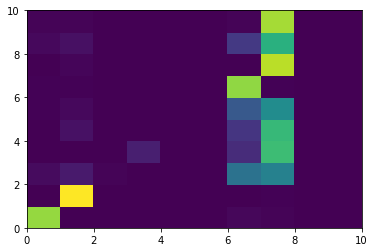

In [63]:
plotconf()

In [64]:
incm.train(old3, 1)

Training loss [0.00652479 0.00374519 0.00162012 0.0026734 ]


array([[0.00652479, 0.00374519, 0.00162012, 0.0026734 ],
       [0.00375502, 0.00240397, 0.00146668, 0.00204797],
       [0.00396137, 0.00229327, 0.0017382 , 0.00200318],
       [0.00429671, 0.00268197, 0.00154264, 0.00190064],
       [0.00379368, 0.00238502, 0.00158966, 0.0021129 ],
       [0.00361426, 0.00264003, 0.00173737, 0.00211549],
       [0.00437666, 0.00301612, 0.00224899, 0.00271861],
       [0.00426188, 0.00297076, 0.00176129, 0.00196407],
       [0.00406482, 0.00299352, 0.00212234, 0.00244915],
       [0.00353421, 0.00287266, 0.00243507, 0.00238966],
       [0.0032773 , 0.00257327, 0.00221818, 0.00192927],
       [0.00360608, 0.00290595, 0.00252466, 0.00201807],
       [0.00301463, 0.00219237, 0.00263206, 0.00216067],
       [0.00346909, 0.00255301, 0.00223178, 0.00198638],
       [0.00368968, 0.00258755, 0.00250954, 0.0023538 ],
       [0.00322653, 0.00193751, 0.00190813, 0.00228683],
       [0.00339815, 0.00252832, 0.00212244, 0.00219132],
       [0.00316063, 0.00247423,

0.5697


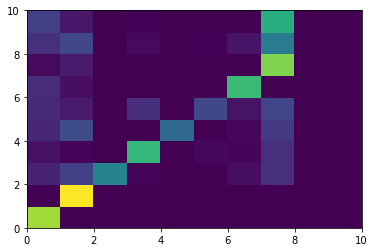

In [65]:
plotconf()

In [66]:
incm.save_weights("si_step4")

# Train on fifth & last pair

In [67]:
h4, lh4 = incm.reconstruct_info(5000, 400, optimizer=keras.optimizers.RMSprop(lr=0.01))

[1.0010648 1.0000747]
[0.18277818 0.17383133]
[0.06983739 0.05505988]
[0.04255334 0.02971426]


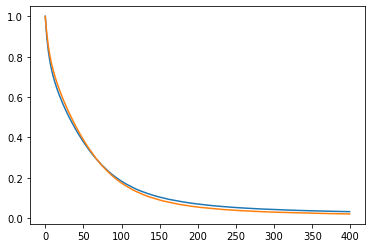

In [68]:
plt.plot(lh4)

In [69]:
old4 = incm.generate_internal(h4, truefwd=False)

In [94]:
incm.load_weights("si_step4")

In [95]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[4], old4, 100, split=[128, 8])

Training loss [0.02409097 0.02495105 0.05884433 0.02457536]


0.4544


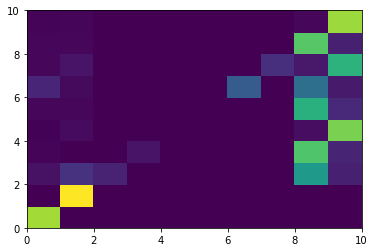

In [96]:
plotconf()

In [97]:
incm.train(old4,1)

Training loss [0.00282104 0.00234553 0.0017885  0.00230118]


array([[0.00282104, 0.00234553, 0.0017885 , 0.00230118],
       [0.0027222 , 0.00193697, 0.00134994, 0.00185786],
       [0.00297118, 0.00219099, 0.00137988, 0.00192752],
       [0.00206951, 0.00190471, 0.0010567 , 0.00148029],
       [0.00212807, 0.00238429, 0.00115599, 0.00190132],
       [0.00221668, 0.00219172, 0.00147292, 0.0020015 ],
       [0.00175336, 0.00171335, 0.00194817, 0.00164951],
       [0.00196738, 0.00159833, 0.0012795 , 0.00141638],
       [0.00199268, 0.00175519, 0.00145467, 0.00179026],
       [0.00189958, 0.00165462, 0.001551  , 0.00159666],
       [0.0021972 , 0.0017736 , 0.00237136, 0.00223306],
       [0.00237463, 0.00190184, 0.00221497, 0.00209246],
       [0.00235376, 0.002063  , 0.00238567, 0.00210481],
       [0.00183893, 0.00138678, 0.00178478, 0.00173736],
       [0.00244941, 0.00212196, 0.00241671, 0.00244555],
       [0.00244106, 0.00190043, 0.00174029, 0.0018876 ],
       [0.00235163, 0.00185123, 0.00161989, 0.00166402],
       [0.00270128, 0.00242429,

0.6636


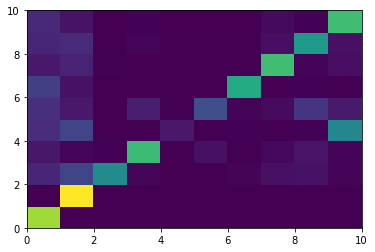

In [98]:
plotconf()

In [102]:
i_accs = [0.2113, 0.3733, 0.4641, 0.5697, 0.6636]
ts_accs = [0.2114, 0.4100, 0.5643, 0.7017, 0.8130]
xy_accs = [0.2114, 0.4144, 0.6001, 0.7922, 0.9824]

In [104]:
dpi=100

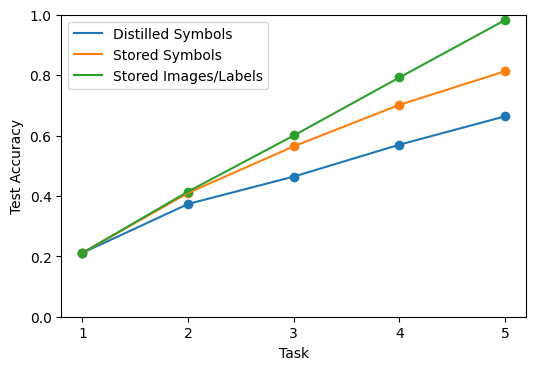

In [115]:
plt.figure(dpi=dpi)
plt.plot(i_accs, '-', label="Distilled Symbols")
plt.plot(ts_accs, '-', label="Stored Symbols")
plt.plot(xy_accs, '-', label="Stored Images/Labels")
plt.scatter(np.arange(0,5), i_accs)
plt.scatter(np.arange(0,5), ts_accs)
plt.scatter(np.arange(0,5), xy_accs)
plt.xticks(np.arange(0,5), np.arange(1,6))
plt.xlabel("Task")
plt.ylabel("Test Accuracy")
plt.ylim(0,1.0)
plt.legend()

In [76]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[4], old4, 25, split=[128, 16])

Training loss [0.03687517 0.03319413 0.02754114 0.030156  ]


0.6636


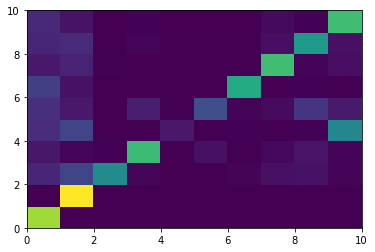

In [118]:
plotconf()

In [64]:
#incm.train(mixed, 2)
loss, dat = incm.train_interleaved(cdp[4], old4, 200, split=[128, 64])

Training loss [0.15548968 0.14059632 0.318475   0.13942079]
Training loss [0.07522865 0.06643294 0.06550051 0.06415924]


0.4445


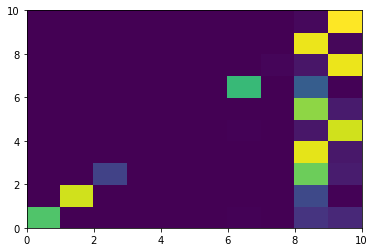

In [65]:
plotconf()

In [59]:
incm.save_weights("si_step5")